In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, default_collate
# from torchview import draw_graph

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_anomaly_scores, plot_train_hist, plot_anomaly_scores_in_out
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 10
        self.ncomps = 100
        self.profiles = []
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/madgan/' + time_id)
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["madgan", "test"]
        self.desc = "PCA diff lr"
        # self.type = "CR1992"
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    window_size=opts.wsize,
    use_pca=True,
    pca_scaler=MinMaxScaler((-1,1)),
    n_components=opts.ncomps,
)
# dataset.filter_profiles(opts.profiles)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Excluding 1179 val files
Removed 631 extreme values
Window size: 10
Window shape:  torch.Size([10, 100])
First window:
 tensor([[ 3.1060e-01, -4.2022e-01,  2.2107e-01, -2.4155e-02, -1.0699e-01,
         -6.5747e-01, -1.8779e-01, -5.0605e-01, -1.9581e-01, -1.6047e-01,
         -3.8729e-01, -7.7865e-02, -9.3559e-02, -1.8211e-01, -3.8515e-02,
         -2.0998e-01, -2.2814e-01,  1.9641e-02, -2.5485e-01, -6.8418e-01,
         -3.4974e-01, -7.2576e-02, -4.2369e-02, -5.8535e-02, -2.6084e-01,
         -8.5047e-02, -8.6709e-02, -6.2540e-03, -1.6441e-01, -2.6055e-02,
         -9.8390e-03, -2.6771e-01, -1.4034e-01, -1.1725e-01, -1.5784e-01,
         -3.7961e-01, -5.4794e-02, -4.9226e-01, -6.2726e-02, -2.4784e-01,
         -1.7440e-01,  1.2729e-03, -1.3999e-02, -2.3533e-02, -1.5254e-01,
         -2.2612e-03, -5.2957e-01, -4.9970e-02, -3.4156e-02, -1.2542e-01,
         -1.7746e-01, -1.5202e-01, -3.5774e-01, -1.5329e-01, -8.0660e-02,
         -3.5080e-01, -1.6142e-01, -1.8048e-01, -1.4815e-01, -2.28

# Models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    nlayers=1,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


In [4]:
netG.train()

Generator(
  (rnn): GRU(100, 200, num_layers=3, batch_first=True)
  (linear): Linear(in_features=200, out_features=100, bias=True)
)

In [6]:
netD.train()

Discriminator(
  (rnn): GRU(100, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
logger = Logger([netG, netD], opts.model_out / f"{time_id}.md", vars(opts))

runs/madgan/0605-1348


# Training

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.D_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.G_lr)

In [10]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for [x, _filenames] in tqdm(dataloader, desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.6: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.flatten(fake.detach().cpu().numpy())
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[0/25]	Loss_D: 0.4287	Loss_G: 4.7165	D(x): 0.9697	D(G(z)): 0.1576


Epoch [1/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[1/25]	Loss_D: 0.2919	Loss_G: 4.9454	D(x): 0.9746	D(G(z)): 0.1146


Epoch [2/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[2/25]	Loss_D: 0.0637	Loss_G: 11.9167	D(x): 0.9791	D(G(z)): 0.0326


Epoch [3/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[3/25]	Loss_D: 0.7160	Loss_G: 18.8929	D(x): 0.9635	D(G(z)): 0.0813


Epoch [4/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[4/25]	Loss_D: 0.5692	Loss_G: 3.8078	D(x): 0.9216	D(G(z)): 0.2552


Epoch [5/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[5/25]	Loss_D: 0.9133	Loss_G: 2.5389	D(x): 0.8966	D(G(z)): 0.3554


Epoch [6/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[6/25]	Loss_D: 0.7567	Loss_G: 1.5170	D(x): 0.8605	D(G(z)): 0.3545


Epoch [7/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[7/25]	Loss_D: 0.9828	Loss_G: 1.1437	D(x): 0.8315	D(G(z)): 0.4397


Epoch [8/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[8/25]	Loss_D: 0.5669	Loss_G: 1.8587	D(x): 0.8216	D(G(z)): 0.2610


Epoch [9/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[9/25]	Loss_D: 1.3603	Loss_G: 0.6542	D(x): 0.7939	D(G(z)): 0.5726


Epoch [10/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[10/25]	Loss_D: 1.4517	Loss_G: 0.6489	D(x): 0.7690	D(G(z)): 0.5834


Epoch [11/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[11/25]	Loss_D: 1.9711	Loss_G: 0.3648	D(x): 0.7699	D(G(z)): 0.7261


Epoch [12/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[12/25]	Loss_D: 1.7410	Loss_G: 0.3725	D(x): 0.8187	D(G(z)): 0.7149


Epoch [13/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[13/25]	Loss_D: 1.3836	Loss_G: 0.4284	D(x): 0.8055	D(G(z)): 0.6609


Epoch [14/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[14/25]	Loss_D: 1.7830	Loss_G: 0.4182	D(x): 0.6608	D(G(z)): 0.6817


Epoch [15/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[15/25]	Loss_D: 1.9056	Loss_G: 0.4187	D(x): 0.5753	D(G(z)): 0.6798


Epoch [16/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[16/25]	Loss_D: 1.9091	Loss_G: 0.3518	D(x): 0.7274	D(G(z)): 0.7264


Epoch [17/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[17/25]	Loss_D: 1.9064	Loss_G: 0.3046	D(x): 0.7738	D(G(z)): 0.7513


Epoch [18/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[18/25]	Loss_D: 1.1708	Loss_G: 0.8362	D(x): 0.6444	D(G(z)): 0.4520


Epoch [19/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[19/25]	Loss_D: 1.1606	Loss_G: 1.2845	D(x): 0.6202	D(G(z)): 0.3551


Epoch [20/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[20/25]	Loss_D: 1.5319	Loss_G: 0.4705	D(x): 0.7311	D(G(z)): 0.6537


Epoch [21/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[21/25]	Loss_D: 1.8264	Loss_G: 0.4227	D(x): 0.5707	D(G(z)): 0.6677


Epoch [22/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[22/25]	Loss_D: 1.8834	Loss_G: 0.3032	D(x): 0.7630	D(G(z)): 0.7532


Epoch [23/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[23/25]	Loss_D: 0.9165	Loss_G: 1.4172	D(x): 0.7828	D(G(z)): 0.4065


Epoch [24/25]:   0%|          | 0/78 [00:00<?, ?it/s]

[24/25]	Loss_D: 1.4149	Loss_G: 0.9142	D(x): 0.7757	D(G(z)): 0.5329


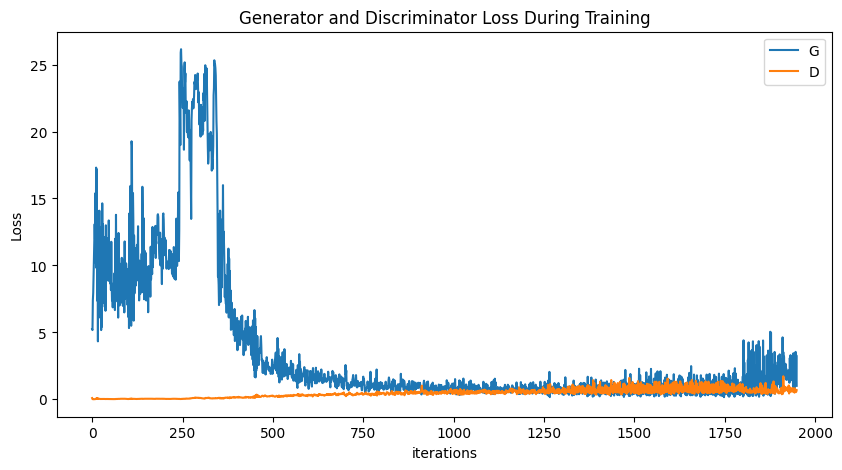

In [11]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [12]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [13]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [14]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [15]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("runs/madgan/0322-1636")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
    data_compiled=Path("../data/compiled")
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [16]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
# eval_dataset.filter_profiles(opts.profiles)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 10
Window shape:  torch.Size([10, 100])
First window:
 tensor([[ 3.1060e-01, -4.2022e-01,  2.2107e-01, -2.4155e-02, -1.0699e-01,
         -6.5747e-01, -1.8779e-01, -5.0605e-01, -1.9581e-01, -1.6047e-01,
         -3.8729e-01, -7.7865e-02, -9.3559e-02, -1.8211e-01, -3.8515e-02,
         -2.0998e-01, -2.2814e-01,  1.9641e-02, -2.5485e-01, -6.8418e-01,
         -3.4974e-01, -7.2576e-02, -4.2369e-02, -5.8535e-02, -2.6084e-01,
         -8.5047e-02, -8.6709e-02, -6.2540e-03, -1.6441e-01, -2.6055e-02,
         -9.8390e-03, -2.6771e-01, -1.4034e-01, -1.1725e-01, -1.5784e-01,
         -3.7961e-01, -5.4794e-02, -4.9226e-01, -6.2726e-02, -2.4784e-01,
         -1.7440e-01,  1.2729e-03, -1.3999e-02, -2.3533e-02, -1.5254e-01,
         -2.2612e-03, -5.2957e-01, -4.9970e-02, -3.4156e-02, -1.2542e-01,
         -1.7746e-01, -1.5202e-01, -3.5774e-01, -1.5329e-01, -8.0660e-02,
         -3.5080e-01, -1.6142e-01, -1.8048e-01, -1.4815e-01, -2.2833e-01,
         -3.2281e-01, -1.0657e-01, -1.9498e-

## Discriminator Classification

In [17]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.7484697103500366
Found 352 anomalies


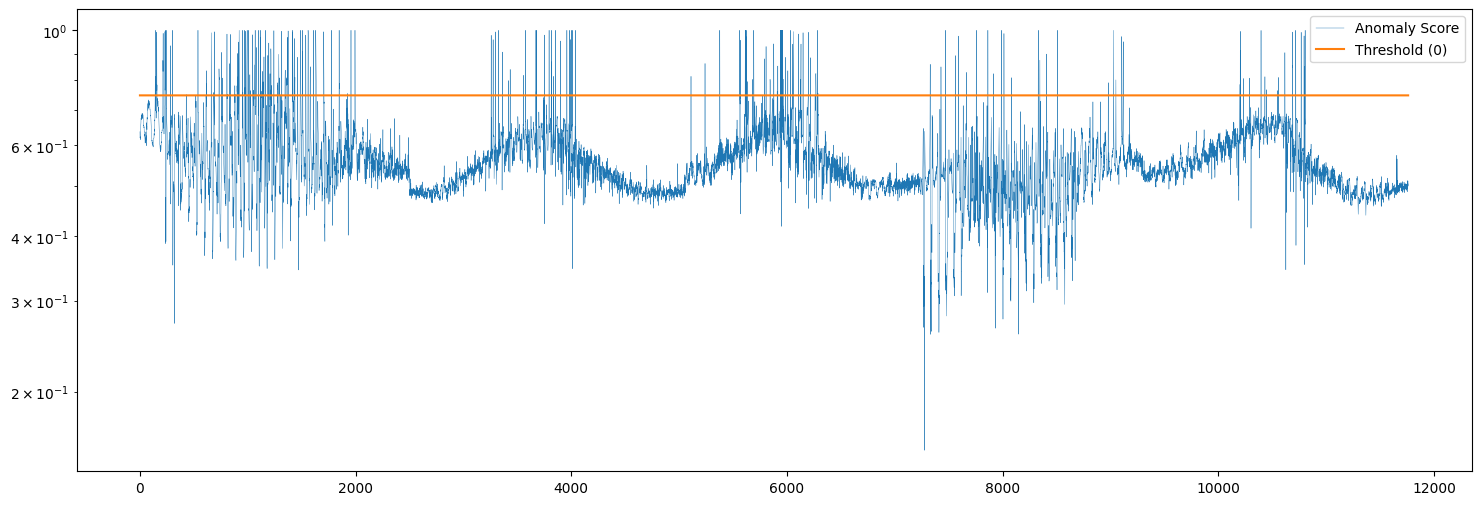

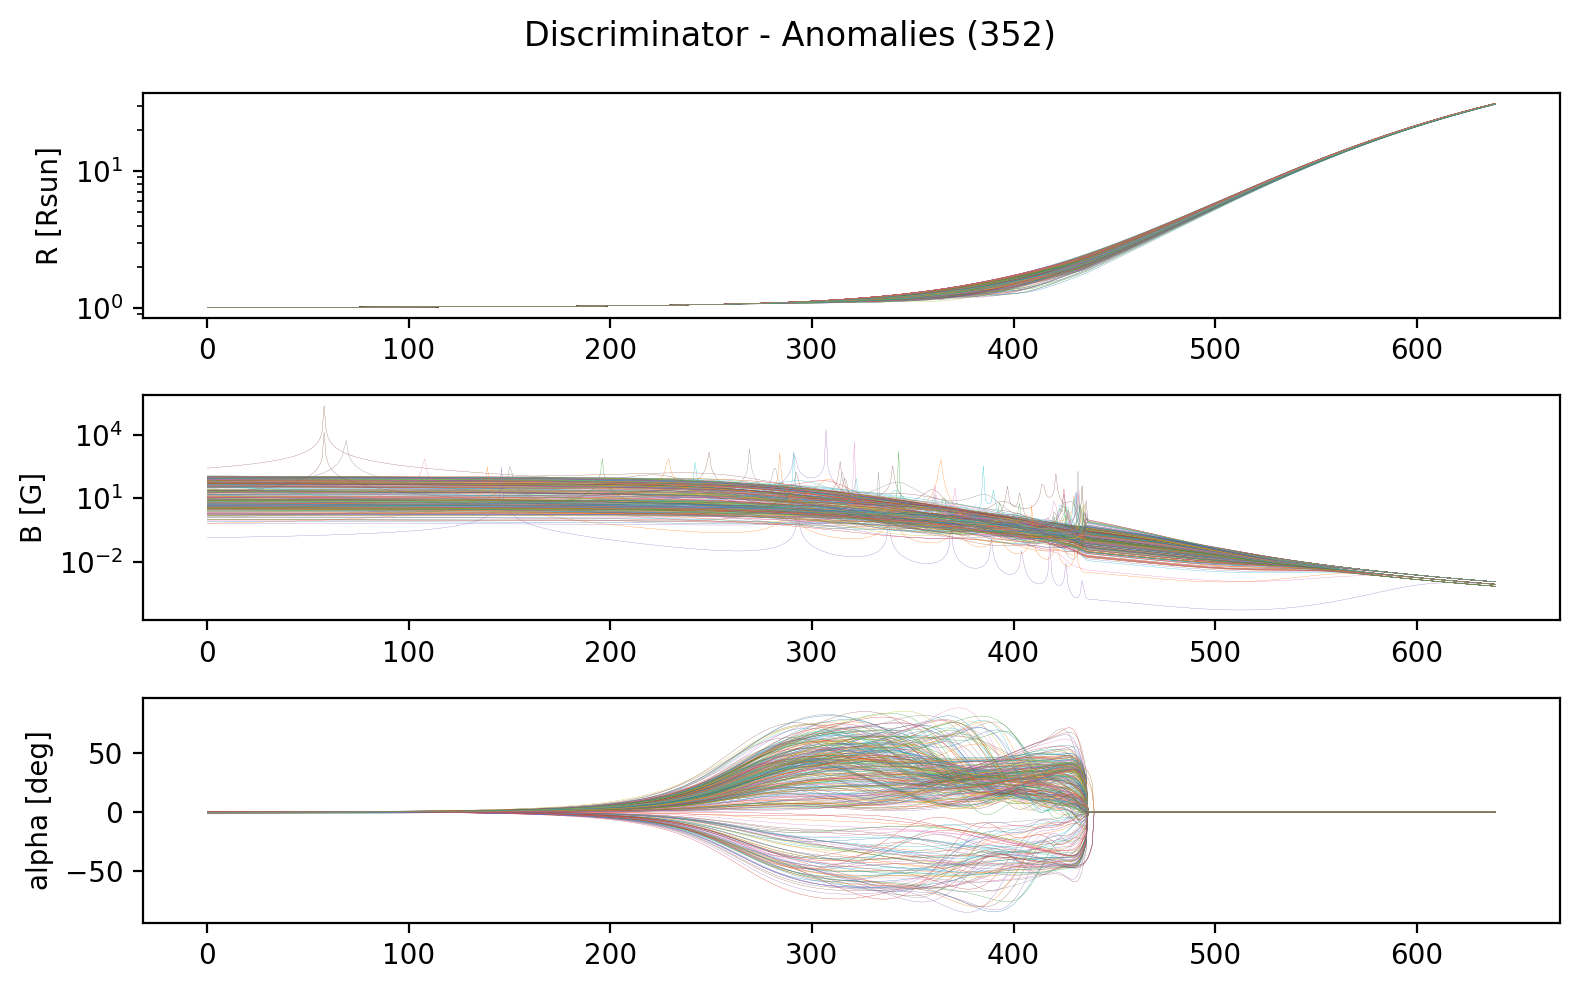

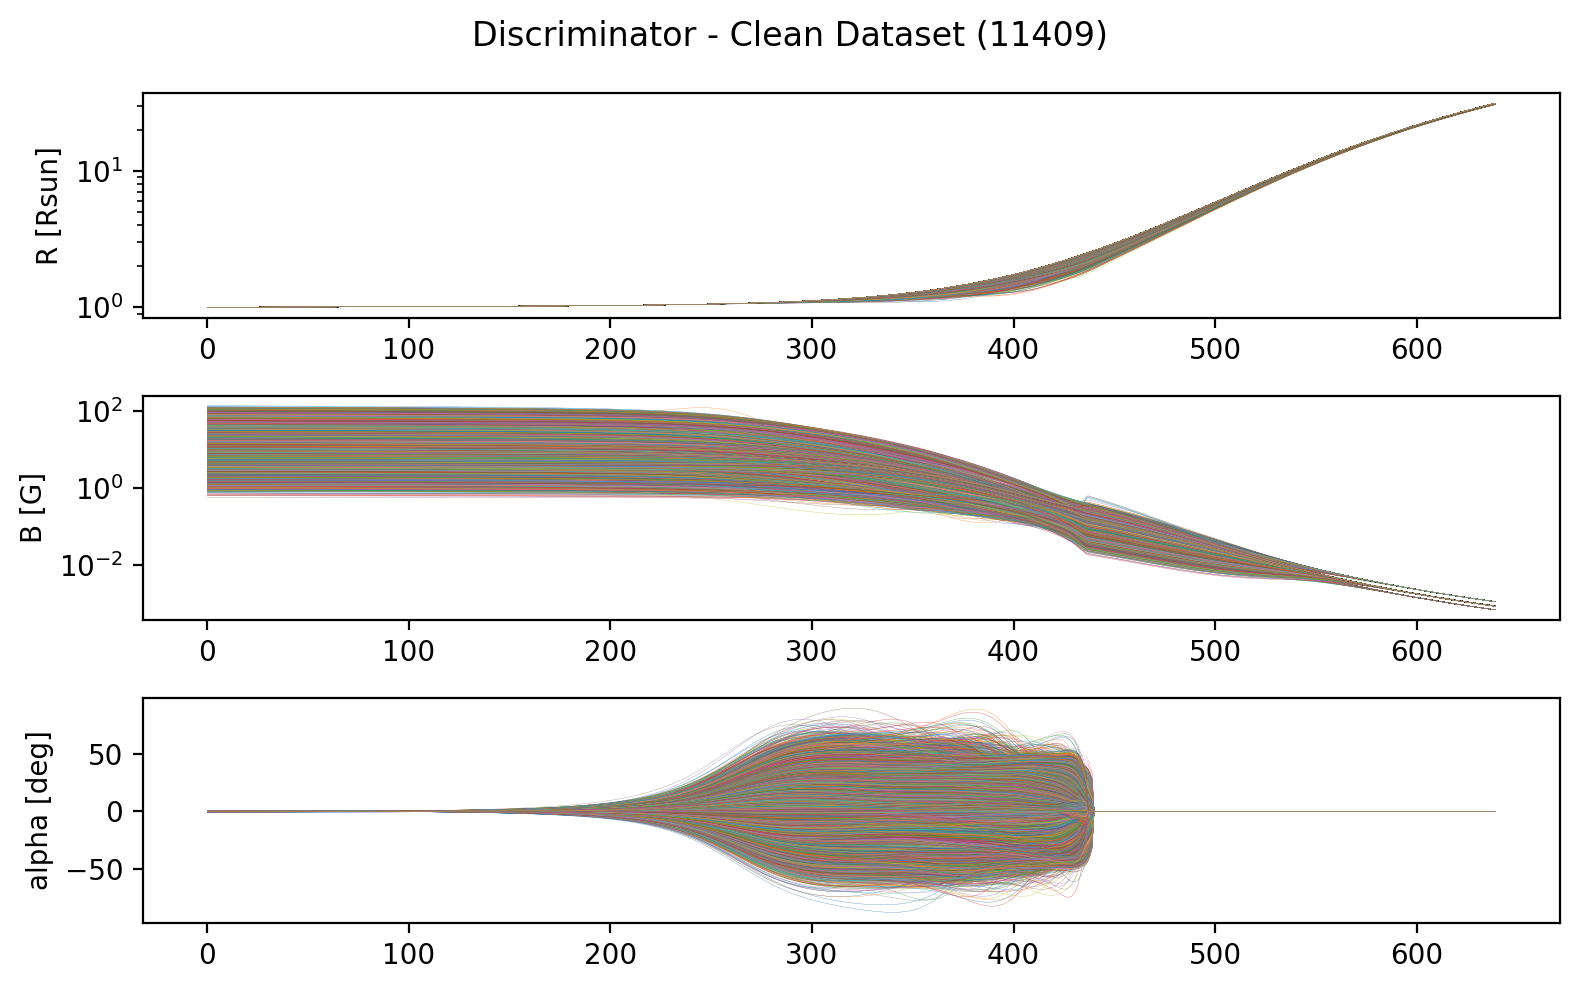

In [18]:
anomalies =\
    plot_anomaly_scores(scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/discr",
                        scale="log", method="Discriminator", normal_plot=True)
logger.save_anomalies(anomalies, "discr")

## Reconstruction Based

In [19]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [20]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  7.314276
Found 352 anomalies


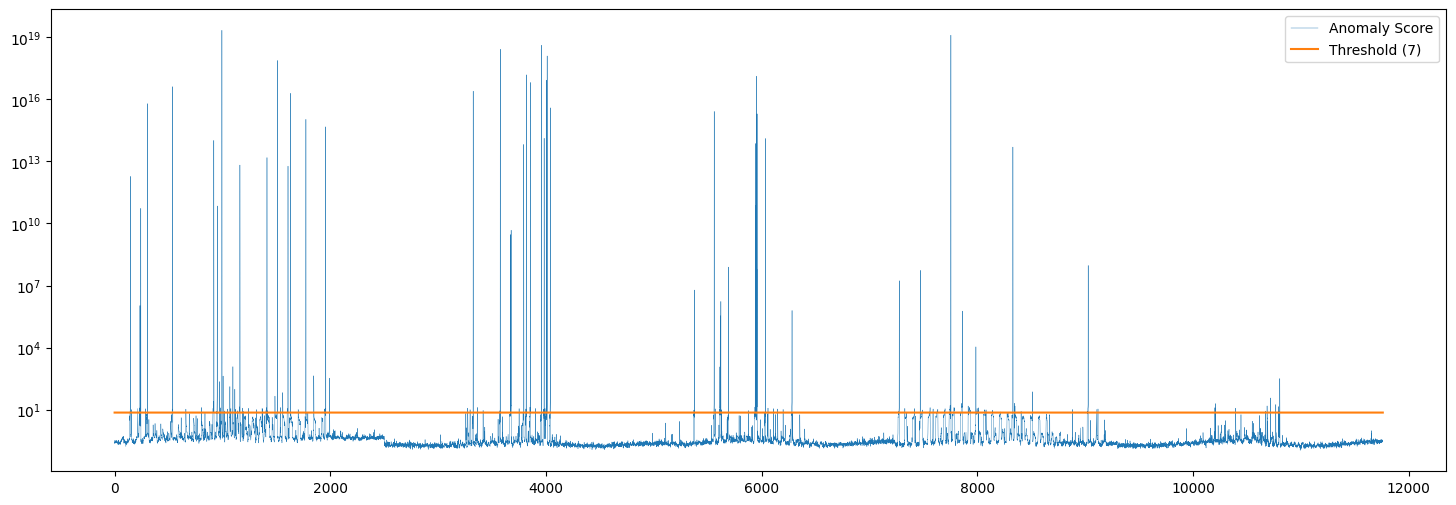

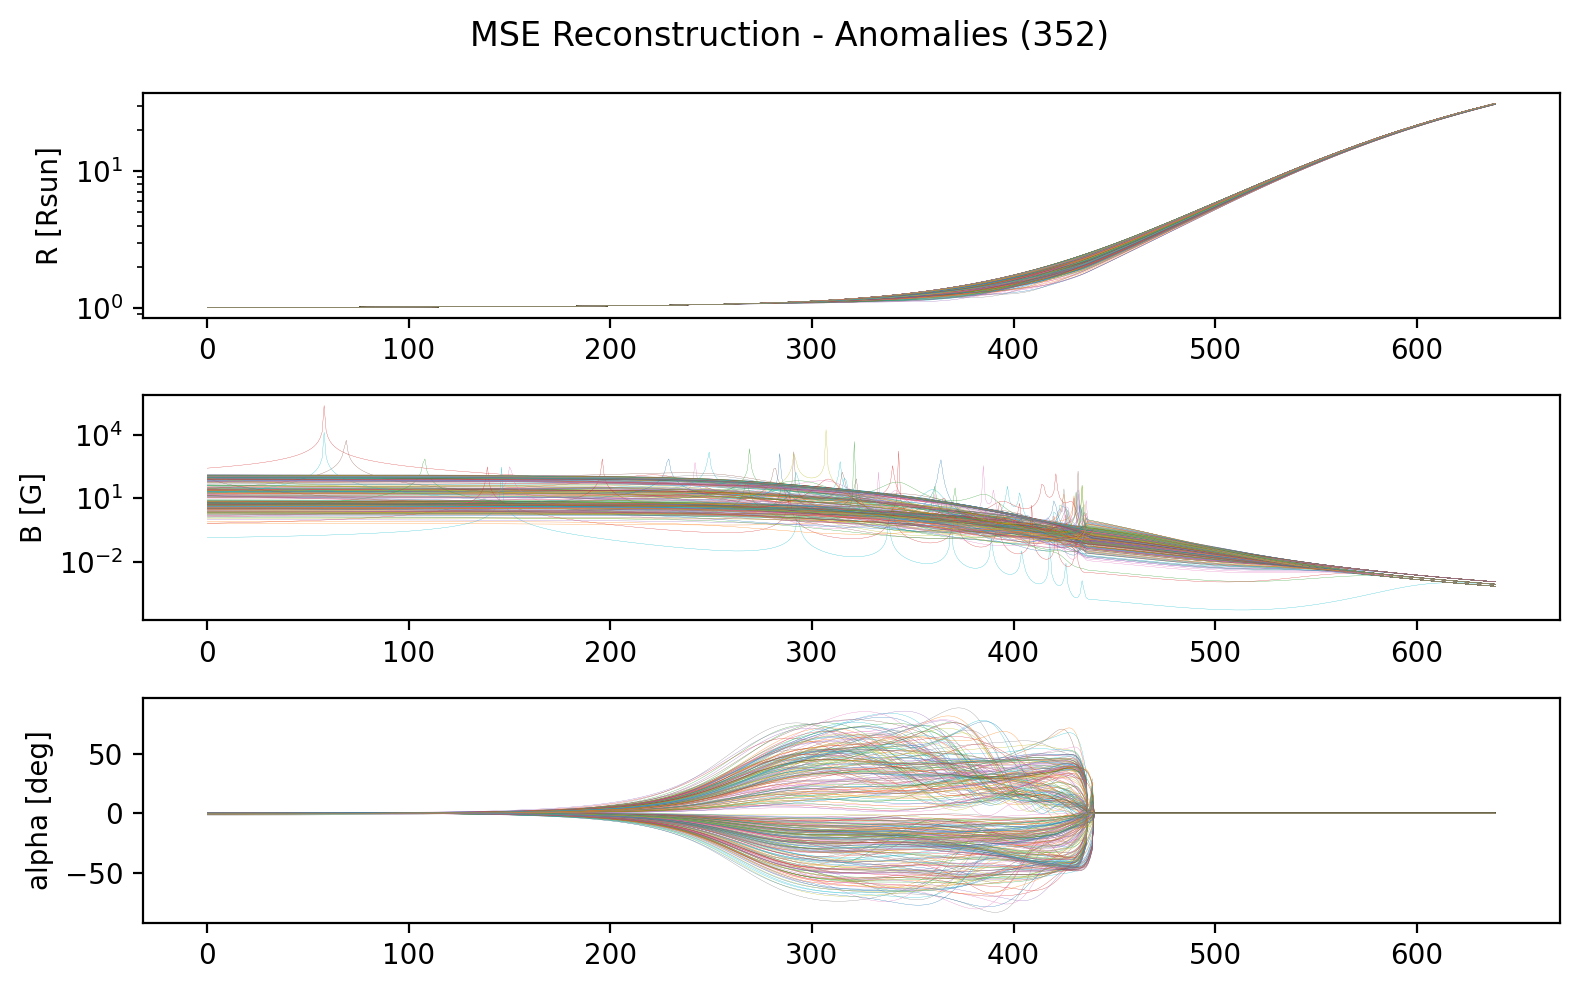

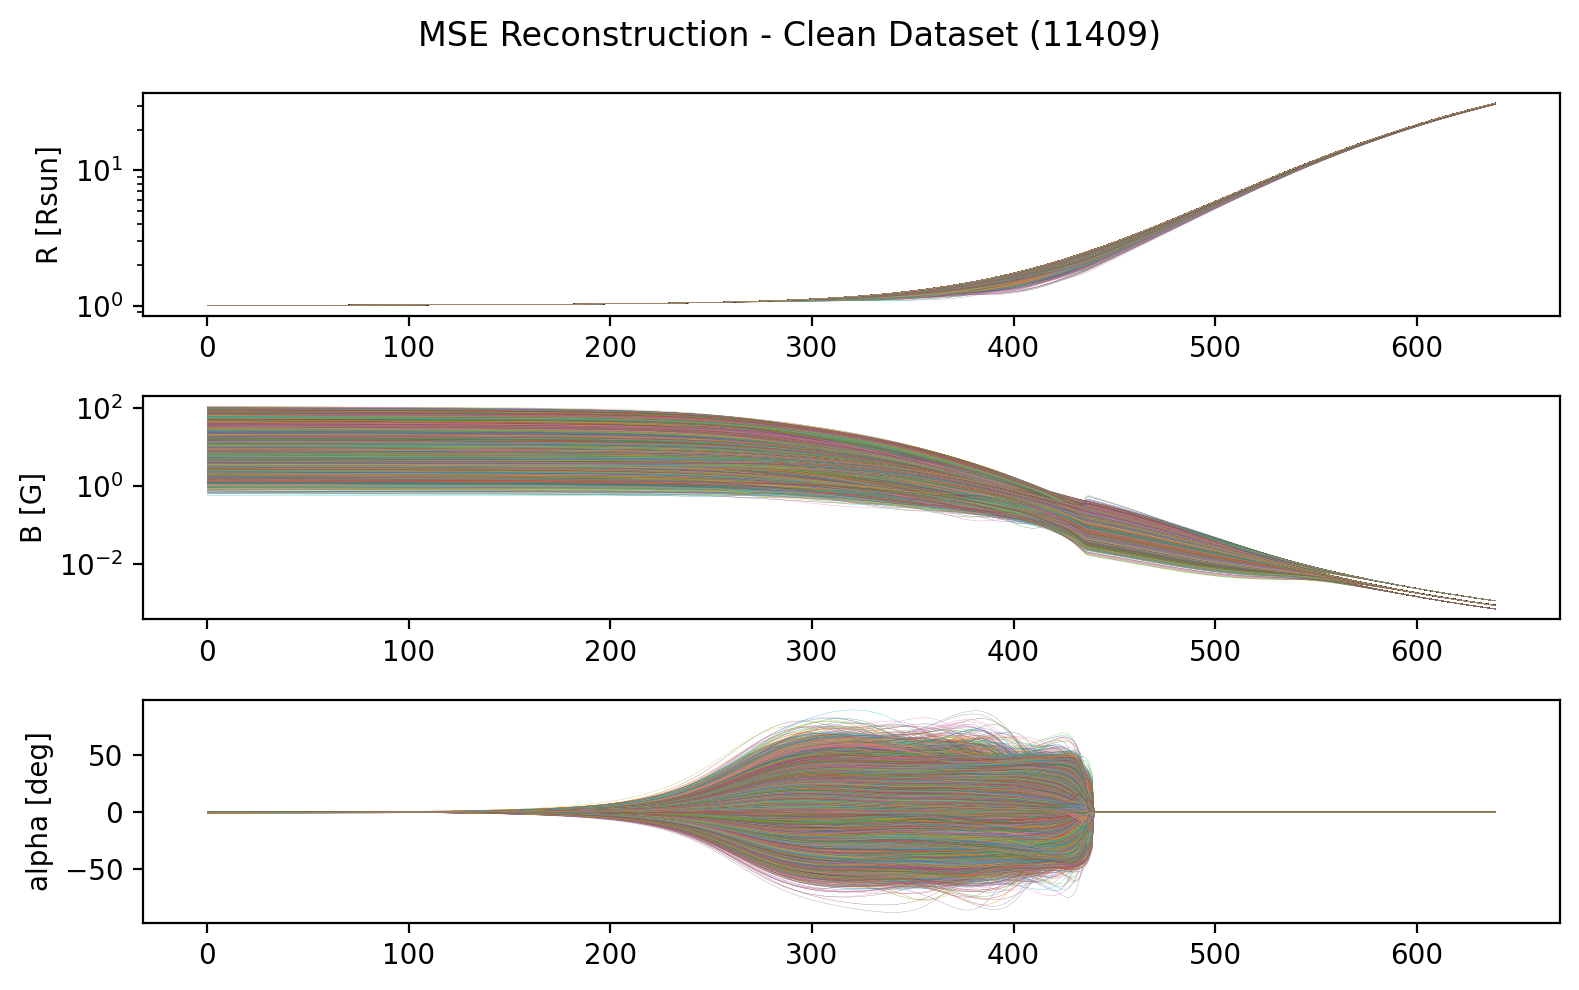

In [21]:
anomalies =\
    plot_anomaly_scores(reconstr_scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE Reconstruction", normal_plot=True)
logger.save_anomalies(anomalies, "mse")

### MSE Reconstruction with Discriminator feedback

In [22]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.4209767
Found 352 anomalies


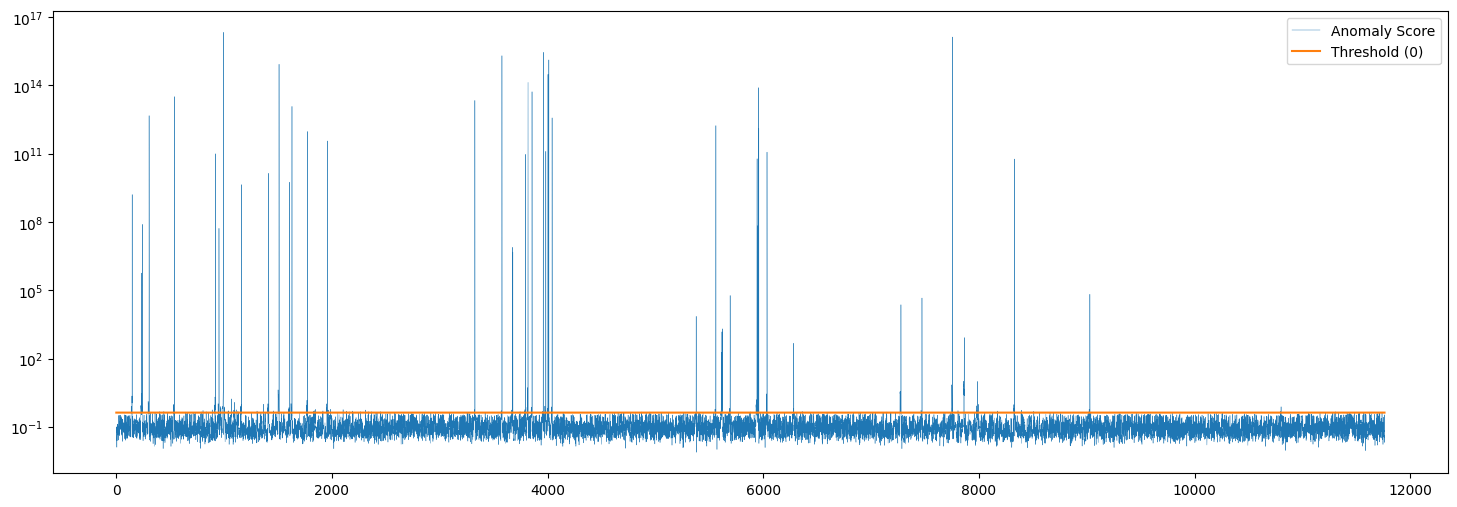

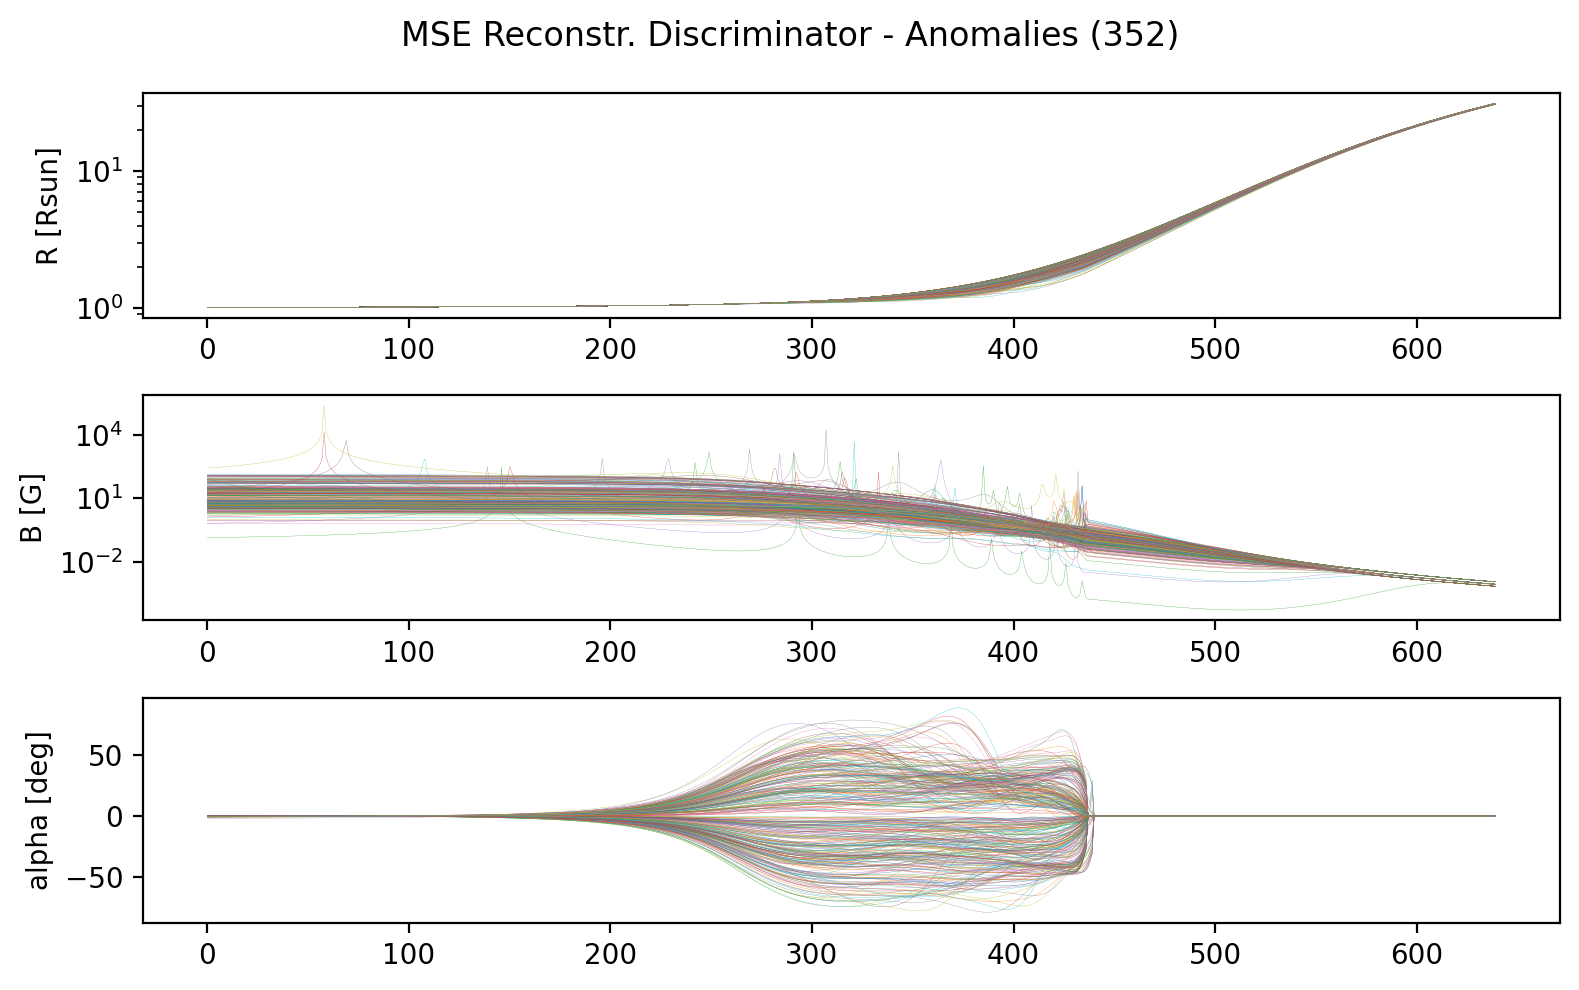

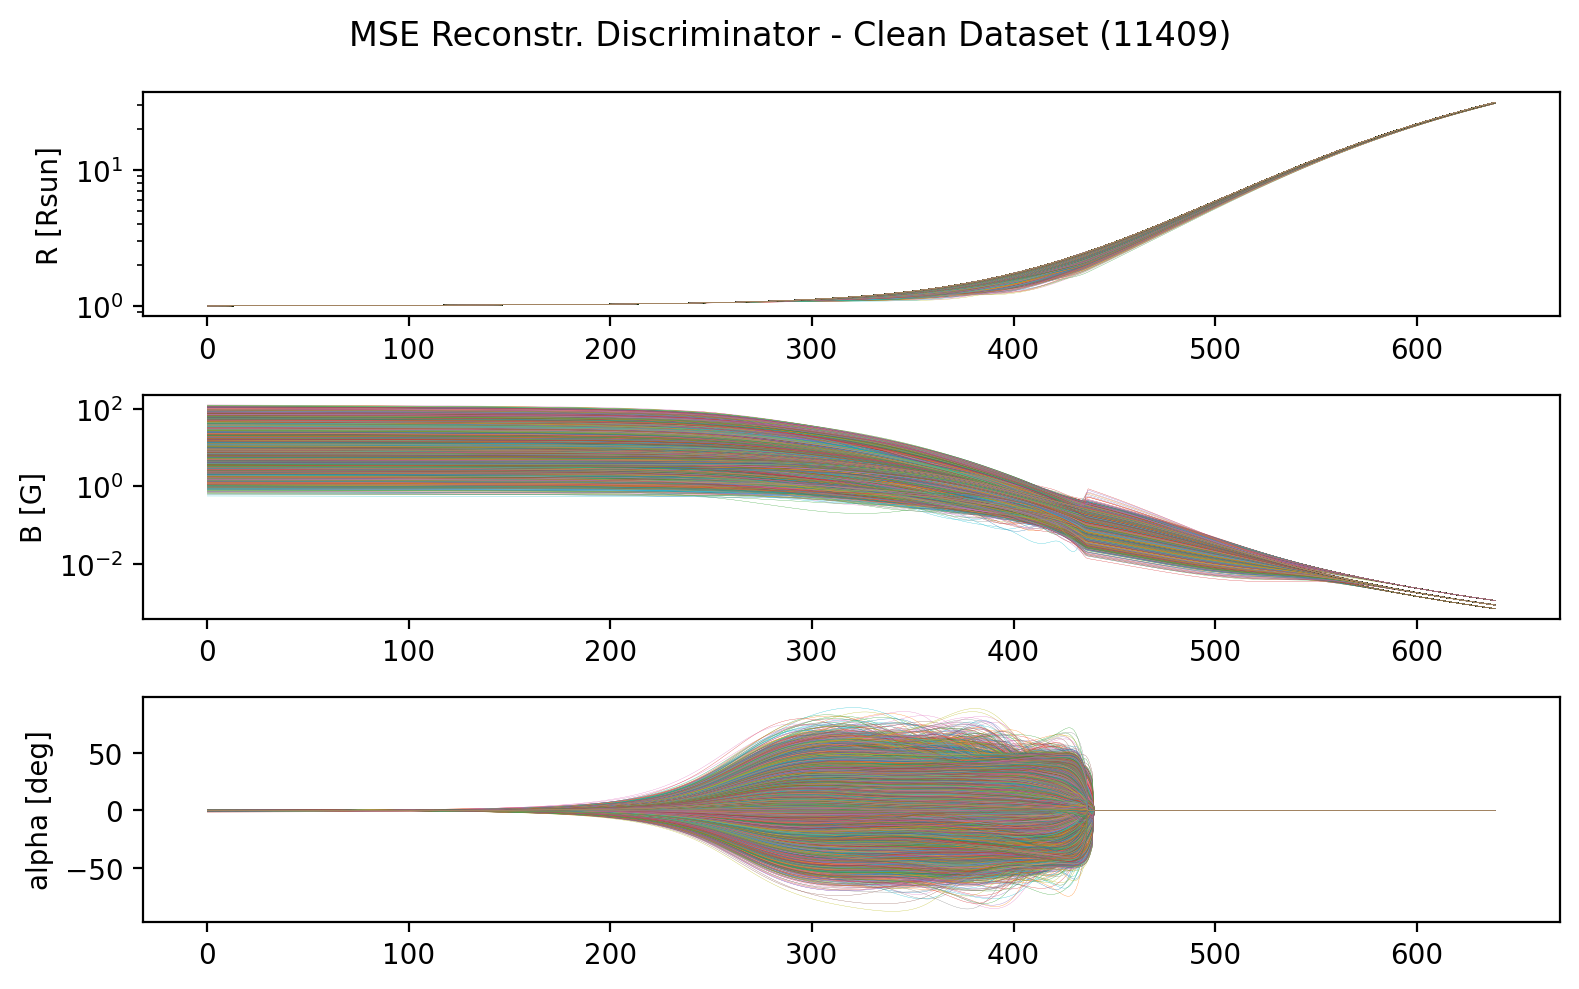

In [23]:
anomalies =\
    plot_anomaly_scores(reconstr_scores_discr, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE Reconstr. Discriminator", normal_plot=True)
logger.save_anomalies(anomalies, "mse_discr")